In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os

import logging
logging.getLogger().setLevel(logging.INFO)

from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
from alphabase.spectral_library.reader import LibraryReaderBase
from tqdm import tqdm
from alphabase.peptide.precursor import get_mod_seq_formula
from alphabase.constants.isotope import IsotopeDistribution
from alphadia.extraction.utils import reannotate_fragments
from alphabase.psm_reader import psm_reader_provider

INFO:root:


In [2]:
import warnings 

def fragment_number(precursor_df, fragment_intensity_df) :
    if not set(['frag_start_idx', 'frag_stop_idx']).issubset(precursor_df.columns):
        warnings.warn('frag_start_idx and frag_stop_idx not in dataframe')
        return
    
    n_fragments = []
    
    for start, stop in zip(precursor_df['frag_start_idx'].values, precursor_df['frag_stop_idx'].values):
        n_fragments += [np.sum(fragment_intensity_df.iloc[start:stop].values > 0)]

    precursor_df['n_fragments'] = n_fragments

def calc_isotope_dist(precursor_df, max_isotope = 6, min_intensity = 0.001):
    isotope_dist = IsotopeDistribution()

    col_names = ['i_{}'.format(i) for i in range(max_isotope)]
    precursor_df[col_names] = 0.

    for i in tqdm(range(len(precursor_df))):

        row = precursor_df.iloc[i]
        dist, mono = isotope_dist.calc_formula_distribution(
            get_mod_seq_formula(row['sequence'], row['mods'])
        )
        dist[dist < 0.001] = 0.
        dist = dist / dist.sum()
        precursor_df.loc[i, col_names] = dist[:max_isotope]

In [3]:
lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/4split_DIANNlib_pass_SM03_50files_splitSearch_FengLib4.tsv'
#insilico_lib_location = '/Users/georgwallmann/Documents/data/libraries/2022_111_brunner_2022_1ng_all_29_human_trypsin_diann_decoy.hdf'
output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/marvin_scp/4split_DIANNlib_pass_SM03_50files_splitSearch_d0_d4_d8_d12_shared_eg_unlimited_fragments.hdf'

In [4]:
# create dense library from diann psm file
target_lib = LibraryReaderBase()
target_lib.add_modification_mapping(
    {'Oxidation@M':['M(Oxidation)'],
     'Dimethyl@K':['K(Dimethyl)'],
     'Dimethyl@R':['R(Dimethyl)'],
     'Dimethyl@Any N-term':['(Dimethyl)']
    }
)
psm = target_lib.import_file(lib_location)

In [5]:
target_lib.precursor_df

,mods,precursor_mz,rt,proteins,nAA,mobility,charge,genes,mod_sites,sequence,frag_start_idx,frag_stop_idx,rt_norm,ccs
0,Dimethyl@Any N-term,297.81287,-20.764530,CBS_HUMAN,7,0.727604,3,CBS,0,MIEDAER,0,6,-0.201596,443.904351
1,Dimethyl@Any N-term,297.81287,-9.170625,RAB7A_HUMAN,7,0.711458,3,RAB7A,0,EVMVDDR,6,12,-0.089035,434.053941
2,Dimethyl@Any N-term,297.81287,-2.019791,SYAC_HUMAN,7,0.713229,3,AARS1,0,VMDDLDR,12,18,-0.019610,435.134319
3,Dimethyl@Any N-term,297.82388,-14.433876,SAP18_HUMAN,7,0.722396,3,SAP18,0,EVYPEAR,18,24,-0.140134,440.726564
4,Dimethyl@Any N-term,297.82388,-8.521379,CMBL_HUMAN,7,0.709205,3,CMBL,0,PYIDEAR,24,30,-0.082731,432.678688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117115,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K;Dim...,924.97791,69.963455,GNA1_HUMAN,15,1.114583,2,GNPNAT1,0;1;2;15,MKPDETPMFDPSLLK,1379648,1379662,0.679253,449.755734
117116,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K;Dim...,935.52899,31.377110,SF3A2_HUMAN,18,1.102500,2,SF3A2,0;1;3;18,MEKPPAPPSLPAGPPGVK,1379662,1379679,0.304630,444.842444
117117,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K;Dim...,1029.53740,51.088932,PRDX6_HUMAN,18,1.194479,2,PRDX6,0;6;17;18,DGDSVMVLPTIPEEEAKK,1379679,1379696,0.496006,481.630112
117118,Dimethyl@Any N-term;Oxidation@M;Dimethyl@K;Dim...,1105.05320,3.698964,CRERF_HUMAN,18,1.230682,2,CREBRF,0;8;10;18,PTSSTQIMVKTNMYHNEK,1379696,1379713,0.035912,496.000007


In [6]:

target_lib.precursor_df['decoy'] = 0
target_lib._precursor_df['channel'] = 0
target_lib._fragment_mz_df = target_lib._fragment_mz_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
target_lib._fragment_intensity_df = target_lib._fragment_intensity_df[['b_z1', 'b_z2', 'y_z1', 'y_z2']]
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib._precursor_df['elution_group_idx'] = np.arange(len(target_lib._precursor_df))

In [7]:
calc_isotope_dist(target_lib.precursor_df)

100%|██████████| 117120/117120 [00:45<00:00, 2583.20it/s]


In [8]:
from alphabase.constants import modification

modification.add_new_modifications(
    {
        "Dimethyl:d12@Protein N-term": {
        "composition":"H(-2)2H(8)13C(2)"
        },
        "Dimethyl:d12@Any N-term": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@R": {
        "composition":"H(-2)2H(8)13C(2)",
        },
        "Dimethyl:d12@K": {
        "composition":"H(-2)2H(8)13C(2)",
        },
    }
)

In [9]:
from alphabase.peptide import fragment

channel_lib_list = []
for channel, original_mod, new_mod in [
    (4, 'Dimethyl@', 'Dimethyl:2H(4)@'),
    (8, 'Dimethyl@', 'Dimethyl:2H(6)13C(2)@'),
    (12, 'Dimethyl@', 'Dimethyl:d12@')
    ]:

    channel_lib = target_lib.copy()

    channel_lib._precursor_df['mods'] = channel_lib._precursor_df['mods'].str.replace(original_mod, new_mod)
    channel_lib._precursor_df['channel'] = channel
    fragment.update_precursor_mz(channel_lib._precursor_df)
    channel_lib.calc_fragment_mz_df()
    channel_lib_list += [channel_lib]
    channel_lib.precursor_df.head()


In [10]:
for lib in channel_lib_list:
    target_lib.append(lib)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'b_modloss_z2', 'y_modloss_z2', 'y_modloss_z1'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'b_modloss_z2', 'y_modloss_z2', 'y_modloss_z1'}.
  warnings.warn(
/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'b_modloss_z2', 'y_modloss_z2', 'y_modloss_z1'}.
  warnings.warn(


In [11]:
target_lib.precursor_df.sort_values('elution_group_idx', inplace=True)
target_lib.remove_unused_fragments()

In [12]:
target_lib.precursor_df.columns

Index(['mods', 'precursor_mz', 'rt', 'proteins', 'nAA', 'mobility', 'charge',
       'genes', 'mod_sites', 'sequence', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'n_fragments',
       'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [13]:
decoy_lib = target_lib.copy()

In [14]:
decoy_lib._precursor_df = target_lib._precursor_df[target_lib._precursor_df['channel'] == 0].copy()
decoy_lib.remove_unused_fragments()

In [15]:
decoy_lib._precursor_df.columns

Index(['mods', 'precursor_mz', 'rt', 'proteins', 'nAA', 'mobility', 'charge',
       'genes', 'mod_sites', 'sequence', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'n_fragments',
       'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [16]:
from alphabase.spectral_library.decoy import (
    decoy_lib_provider
)
# register 'protein_reverse' to the decoy_lib_provider
import alphabase.protein.protein_level_decoy

decoy_lib_instance = (
    decoy_lib_provider.get_decoy_lib(
        'diann', decoy_lib
    )
)

In [17]:
decoy_lib_instance.calc_precursor_mz()
decoy_lib_instance.precursor_df
decoy_lib_instance.remove_unused_fragments()
decoy_lib_instance.calc_fragment_mz_df()

In [18]:
decoy_lib_instance.precursor_df.columns

Index(['mods', 'precursor_mz', 'rt', 'proteins', 'nAA', 'mobility', 'charge',
       'genes', 'mod_sites', 'sequence', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'n_fragments',
       'elution_group_idx', 'i_0', 'i_1', 'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [19]:
decoy_lib_instance.precursor_df['decoy'] = 1

In [20]:
target_lib.append(decoy_lib_instance)

/Users/georgwallmann/Documents/git/alphabase/alphabase/spectral_library/base.py:190: UserWarning: Unmatched columns in second dataframe will be dropped: {'b_modloss_z1', 'b_modloss_z2', 'y_modloss_z2', 'y_modloss_z1'}.
  warnings.warn(


In [21]:
target_lib.precursor_df['n_fragments_allowed'] = target_lib.precursor_df['n_fragments']

In [22]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)

In [23]:
target_lib.precursor_df = target_lib.precursor_df[target_lib.precursor_df['n_fragments'] >= 3].copy()
target_lib.remove_unused_fragments()

<AxesSubplot:xlabel='n_fragments', ylabel='Count'>

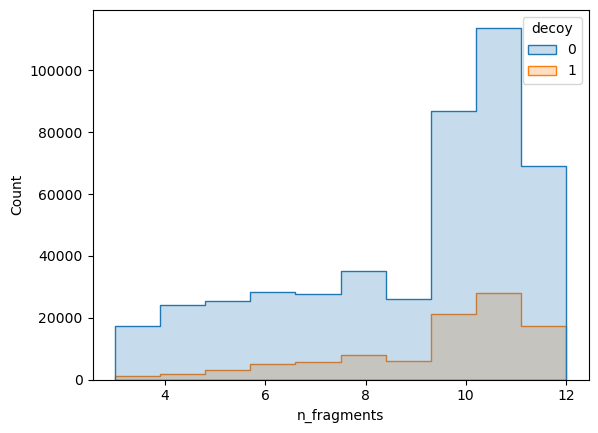

In [24]:
import seaborn as sns
sns.histplot(target_lib.precursor_df, x='n_fragments', hue='decoy', element='step', bins=10)

In [29]:
for i, (start_idx, stop_idx, k_allowed) in enumerate(
    zip(
        target_lib.precursor_df['frag_start_idx'].values, 
        target_lib.precursor_df['frag_stop_idx'].values, 
        target_lib.precursor_df['n_fragments_allowed'].values
        )
    ):
    intensies = target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values
    flat_intensities = np.sort(intensies.flatten())[::-1]
    target_lib._fragment_intensity_df.iloc[start_idx:stop_idx].values[intensies <= flat_intensities[k_allowed]] = 0

In [116]:
target_lib.precursor_df.drop(columns=['n_fragments'], inplace=True)

In [117]:
target_lib.precursor_df.columns

Index(['mobility', 'charge', 'mods', 'sequence', 'nAA', 'proteins', 'genes',
       'rt', 'mod_sites', 'precursor_mz', 'frag_start_idx', 'frag_stop_idx',
       'rt_norm', 'ccs', 'decoy', 'channel', 'elution_group_idx', 'i_0', 'i_1',
       'i_2', 'i_3', 'i_4', 'i_5'],
      dtype='object')

In [25]:
fragment_number(target_lib.precursor_df, target_lib._fragment_intensity_df)
target_lib.fragment_cardinality_df = fragment.calc_fragment_cardinality(target_lib.precursor_df, target_lib._fragment_mz_df)

In [26]:
target_lib.save_hdf(output_location)